In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..\..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.classes.venues import Venue
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import (mission_completion_query,
    mission_completion,
    _mission_completes_details)
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from itertools import zip_longest

In [4]:
replays = get_parsed_replays(lambda g: g.event == 'Winter Cup 2020')

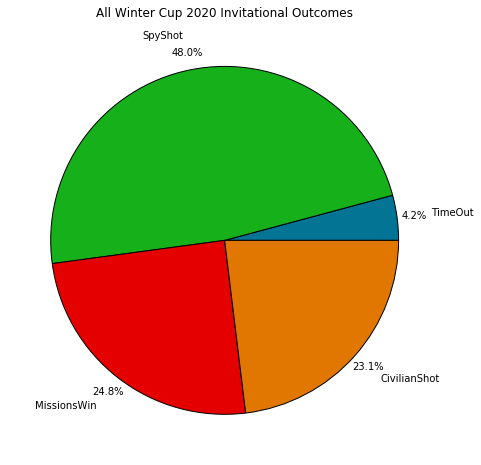

,WinType.TimeOut,WinType.SpyShot,WinType.MissionsWin,WinType.CivilianShot
NaN,46,528,273,254


In [5]:
game_outcomes(
    replays,
    axis_properties=AxisProperties(title="All Winter Cup 2020 Invitational Outcomes")
).frame

### Game Counts

In [6]:
x = sorted(Counter((r.division, r.week, tuple(sorted([r.spy, r.sniper]))) for r in replays).items(), key=lambda x: (x[0][0], x[0][1], x[0][2]))
y = [(_x[0][0], _x[0][1], _x[0][2], _x[1]) for _x in x]
Counter([_y[0] for _y in y])

Counter({'Blitzen': 10,
         'Bracket': 16,
         'Coment': 10,
         'Cupid': 10,
         'Dancer': 8,
         'Dasher': 10,
         'Donner': 10,
         'Prancer': 10,
         'Vixen': 10})

## Group Stage Most Picked / Banned

In [7]:
BigBois = "The Big Bois"
EyeInSky = "Eye in the Sky"
CouldYouSee = "Could you see that?"

In [8]:
map_groups = {
    BigBois: {Venue.Terrace,Venue.Gallery,Venue.Veranda,Venue.Library},
    EyeInSky: {Venue.Balcony,Venue.Pub,Venue.Courtyard,Venue.Moderne},
    CouldYouSee: {Venue.HighRise,Venue.Ballroom,Venue.Aquarium,Venue.Teien},
}

In [9]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [10]:
def identify_groups(played_venues):
    picked_groups = set()
    bans = set()
    for venue in played_venues:
        for group in [BigBois, EyeInSky, CouldYouSee]:
            if venue in map_groups[group]:
                picked_groups.add(group)
        if len(picked_groups) == 2:
            break
            
    for group in picked_groups:
        for venue in map_groups[group]:
            bans.add(venue)
            
    for venue in played_venues:
        bans.discard(venue)
        
    return picked_groups, bans

In [11]:
sorted_group_replays = sorted([r for r in replays if r.division != 'bracket'], key=lambda g: (g.division, sorted([g.spy, g.sniper]), g.start_time))
twelve_game_sets = Counter((tuple(sorted([g.spy, g.sniper])) for g in sorted_group_replays))
twelve_set_pairs = [k for k,v in twelve_game_sets.items() if v == 12]
only_full_set_replays = [g for g in sorted_group_replays if tuple(sorted([g.spy, g.sniper])) in twelve_set_pairs]

In [12]:
all_group_picks = Counter()
all_bans = Counter()

for g in grouper(only_full_set_replays, 12):
    groups, bans = identify_groups([r.venue for r in g])
    all_group_picks.update(Counter(groups))
    all_bans.update(Counter(bans))
    

In [13]:
all_group_picks.most_common()

[('The Big Bois', 64), ('Could you see that?', 46), ('Eye in the Sky', 44)]

In [14]:
all_bans.most_common()

[(<Venue.Balcony: 2>, 20),
 (<Venue.Teien: 11>, 19),
 (<Venue.Veranda: 13>, 18),
 (<Venue.Terrace: 12>, 17),
 (<Venue.Courtyard: 4>, 17),
 (<Venue.HighRise: 6>, 13),
 (<Venue.Aquarium: 1>, 12),
 (<Venue.Gallery: 5>, 11),
 (<Venue.Library: 7>, 10),
 (<Venue.Moderne: 8>, 10),
 (<Venue.Pub: 9>, 4),
 (<Venue.Ballroom: 3>, 4)]

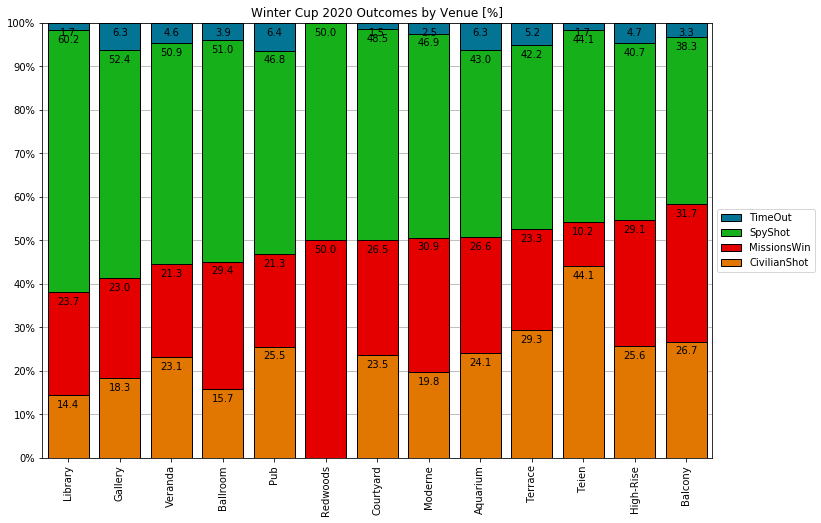

,Venue.Library,Venue.Gallery,Venue.Veranda,Venue.Ballroom,Venue.Pub,Venue.Redwoods,Venue.Courtyard,Venue.Moderne,Venue.Aquarium,Venue.Terrace,Venue.Teien,Venue.HighRise,Venue.Balcony
WinType.TimeOut,0.016949,0.063492,0.046296,0.039216,0.063830,0.0,0.014706,0.024691,0.063291,0.051724,0.016949,0.046512,0.033333
WinType.SpyShot,0.601695,0.523810,0.509259,0.509804,0.468085,0.5,0.485294,0.469136,0.430380,0.422414,0.440678,0.406977,0.383333
WinType.MissionsWin,0.237288,0.230159,0.212963,0.294118,0.212766,0.5,0.264706,0.308642,0.265823,0.232759,0.101695,0.290698,0.316667
WinType.CivilianShot,0.144068,0.182540,0.231481,0.156863,0.255319,0.0,0.235294,0.197531,0.240506,0.293103,0.440678,0.255814,0.266667


In [15]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

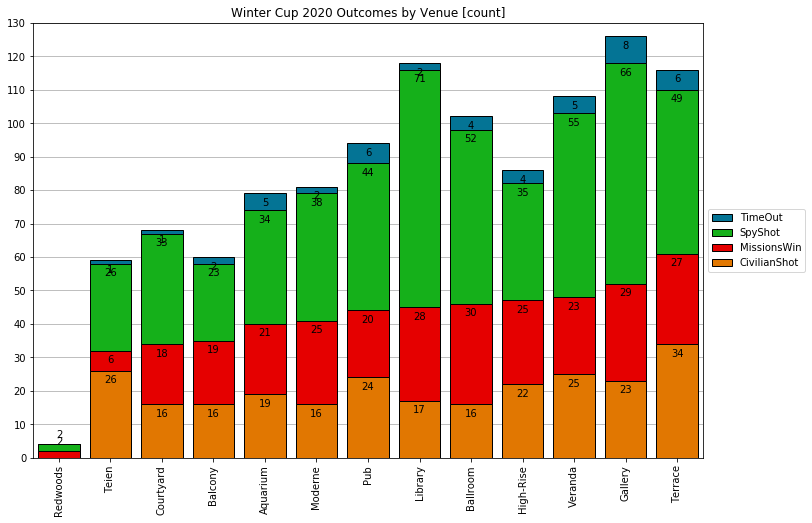

,Venue.Redwoods,Venue.Teien,Venue.Courtyard,Venue.Balcony,Venue.Aquarium,Venue.Moderne,Venue.Pub,Venue.Library,Venue.Ballroom,Venue.HighRise,Venue.Veranda,Venue.Gallery,Venue.Terrace
WinType.TimeOut,0,1,1,2,5,2,6,2,4,4,5,8,6
WinType.SpyShot,2,26,33,23,34,38,44,71,52,35,55,66,49
WinType.MissionsWin,2,6,18,19,21,25,20,28,30,25,23,29,27
WinType.CivilianShot,0,26,16,16,19,16,24,17,16,22,25,23,34


In [16]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [count]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

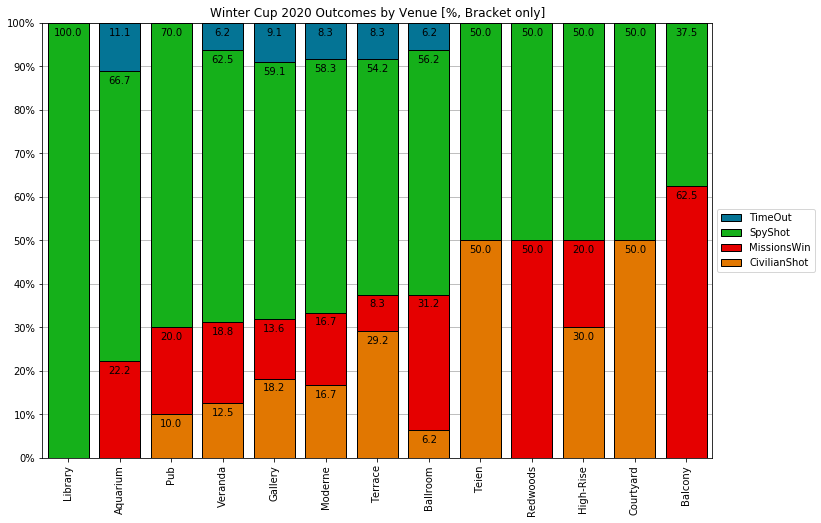

,Venue.Library,Venue.Aquarium,Venue.Pub,Venue.Veranda,Venue.Gallery,Venue.Moderne,Venue.Terrace,Venue.Ballroom,Venue.Teien,Venue.Redwoods,Venue.HighRise,Venue.Courtyard,Venue.Balcony
WinType.TimeOut,0.0,0.111111,0.0,0.0625,0.090909,0.083333,0.083333,0.0625,0.0,0.0,0.0,0.0,0.000
WinType.SpyShot,1.0,0.666667,0.7,0.6250,0.590909,0.583333,0.541667,0.5625,0.5,0.5,0.5,0.5,0.375
WinType.MissionsWin,0.0,0.222222,0.2,0.1875,0.136364,0.166667,0.083333,0.3125,0.0,0.5,0.2,0.0,0.625
WinType.CivilianShot,0.0,0.000000,0.1,0.1250,0.181818,0.166667,0.291667,0.0625,0.5,0.0,0.3,0.5,0.000


In [17]:
game_outcomes(
    list(filter(lambda g: g.division == 'Bracket', replays)),
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [%, Bracket only]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

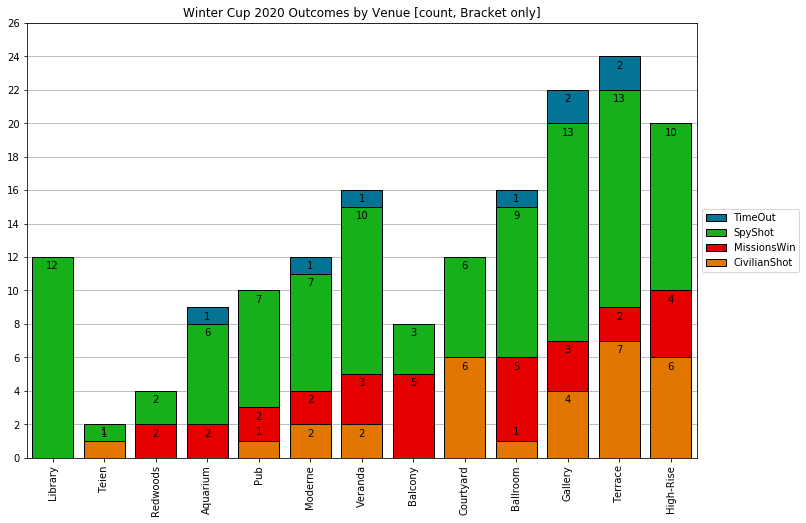

,Venue.Library,Venue.Teien,Venue.Redwoods,Venue.Aquarium,Venue.Pub,Venue.Moderne,Venue.Veranda,Venue.Balcony,Venue.Courtyard,Venue.Ballroom,Venue.Gallery,Venue.Terrace,Venue.HighRise
WinType.TimeOut,0,0,0,1,0,1,1,0,0,1,2,2,0
WinType.SpyShot,12,1,2,6,7,7,10,3,6,9,13,13,10
WinType.MissionsWin,0,0,2,2,2,2,3,5,0,5,3,2,4
WinType.CivilianShot,0,1,0,0,1,2,2,0,6,1,4,7,6


In [18]:
game_outcomes(
    list(filter(lambda g: g.division == 'Bracket', replays)),
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [count, Bracket only]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

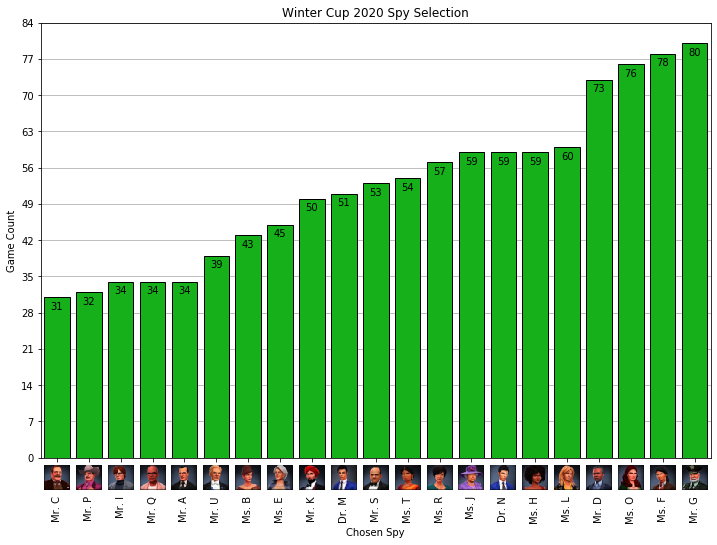

In [19]:
_ = spy_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Spy Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Spy",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

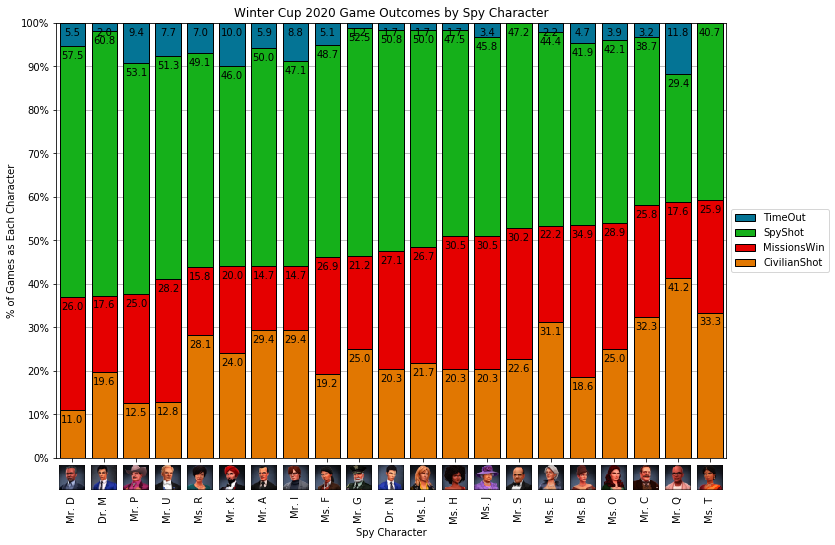

In [20]:
_ = game_outcomes(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Game Outcomes by Spy Character",
        x_axis_portrait=True,
        y_axis_label="% of Games as Each Character",
        x_axis_label="Spy Character",
        data_label_style=PlotLabelStyle.Plain,
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: determine_character_in_role(g, Roles.Spy),
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True
    )
)

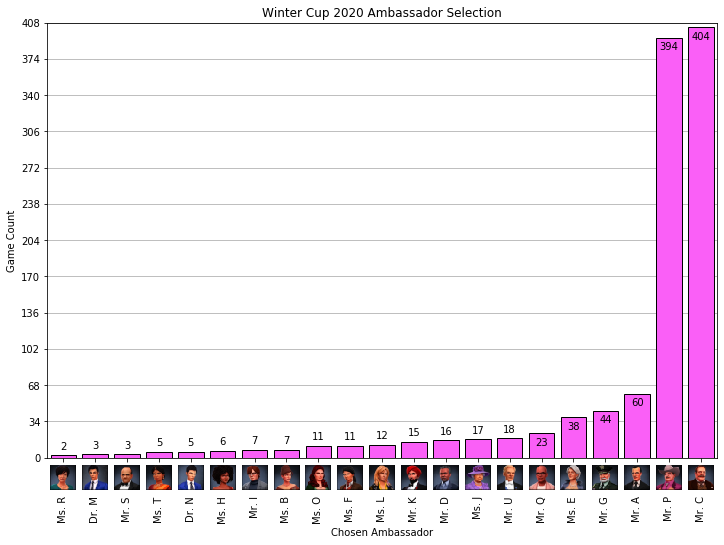

In [21]:
_ = amba_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Ambassador Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Ambassador",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

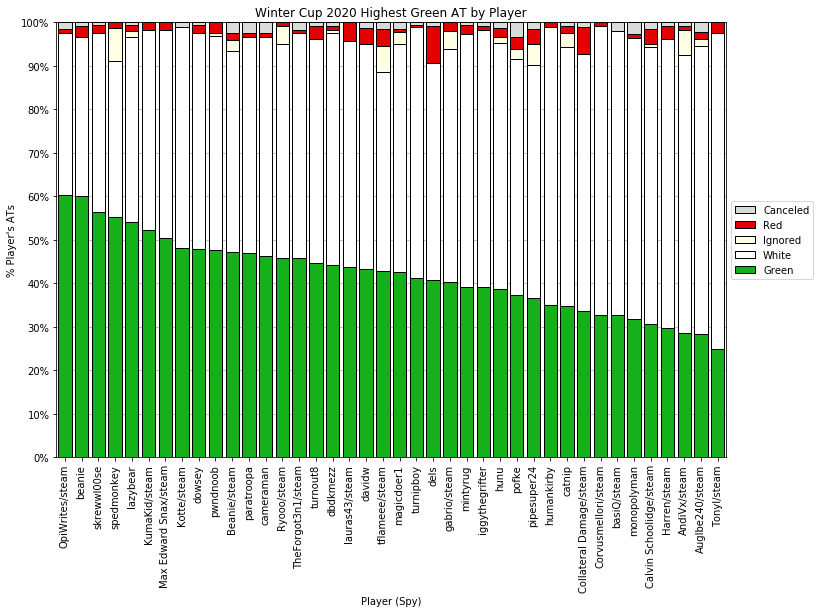

In [22]:
_ = action_test_percentages(
    replays,
    axis_properties = AxisProperties(
        title='Winter Cup 2020 Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

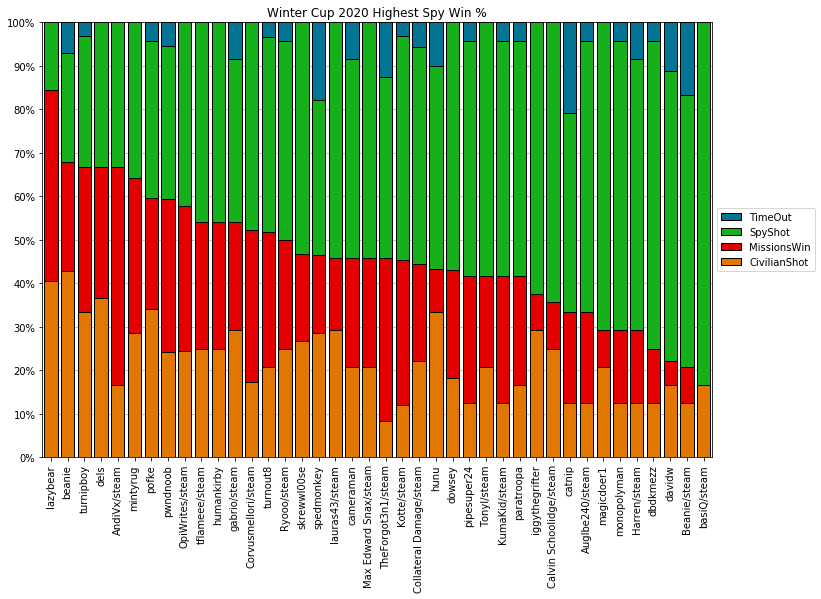

In [23]:
spy_winr = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Spy Win %")
)

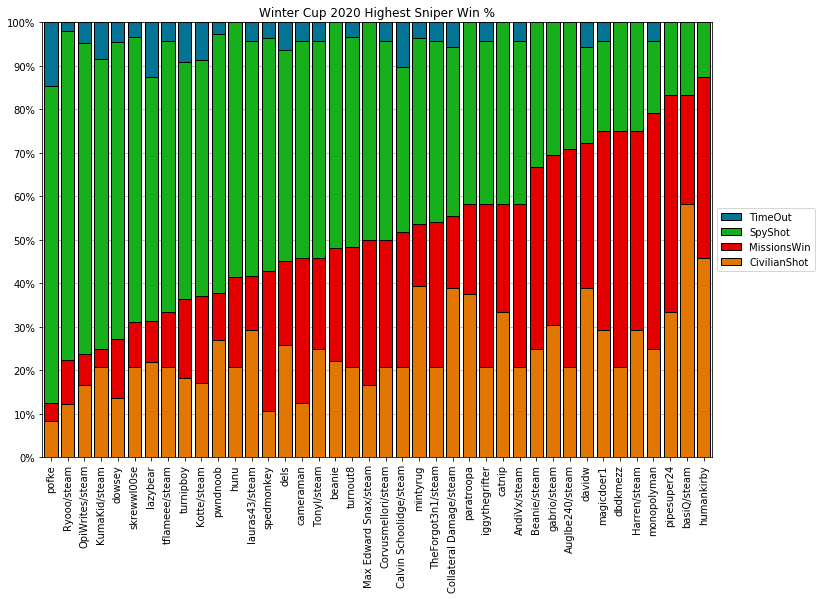

In [24]:
_ = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.sniper,
        secondary_order=sort_by_sniper_wins,
        reverse_secondary_order=True,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Sniper Win %")
)

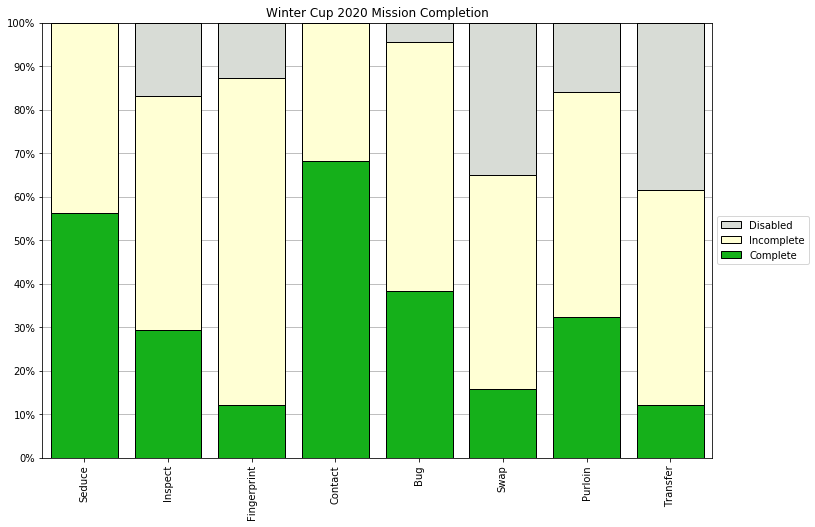

In [25]:
mission_completion(replays, "Winter Cup 2020 Mission Completion")

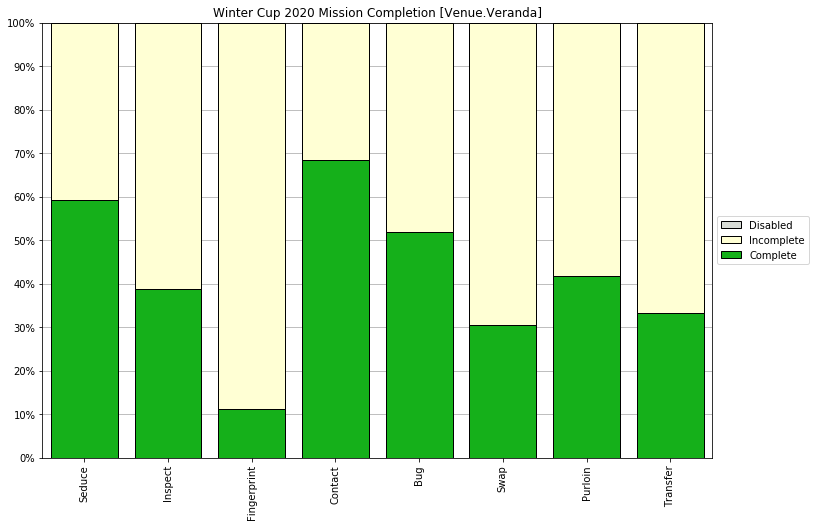

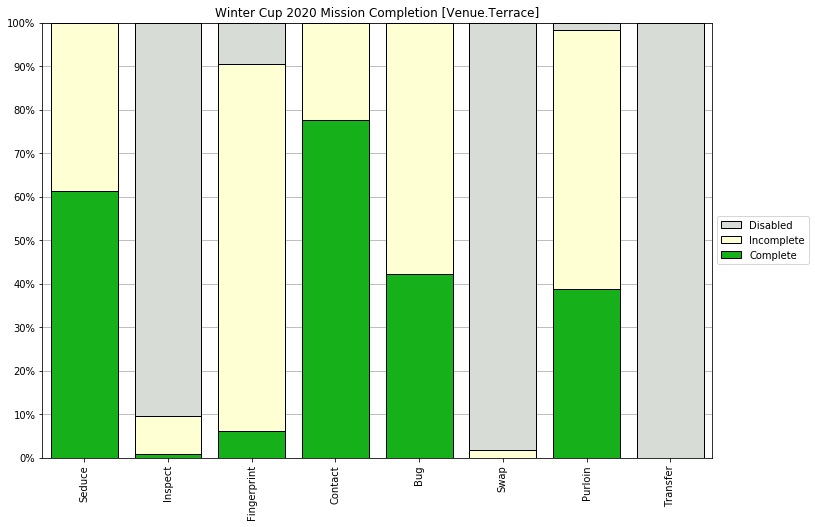

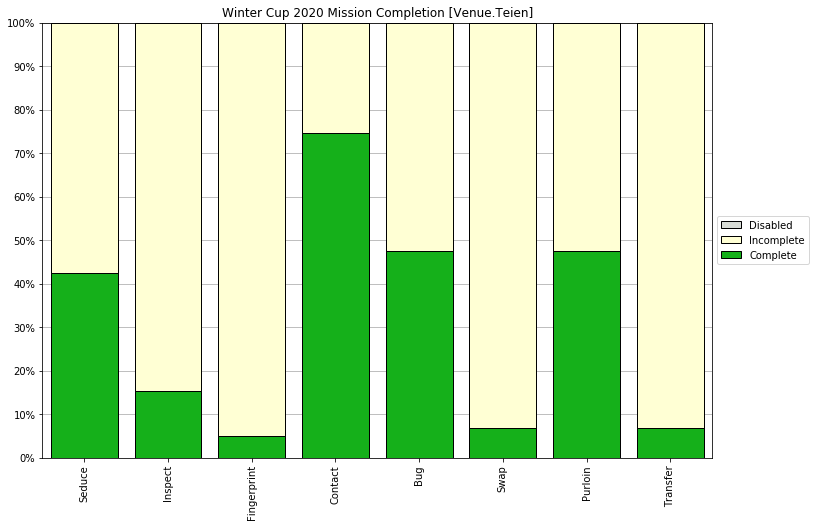

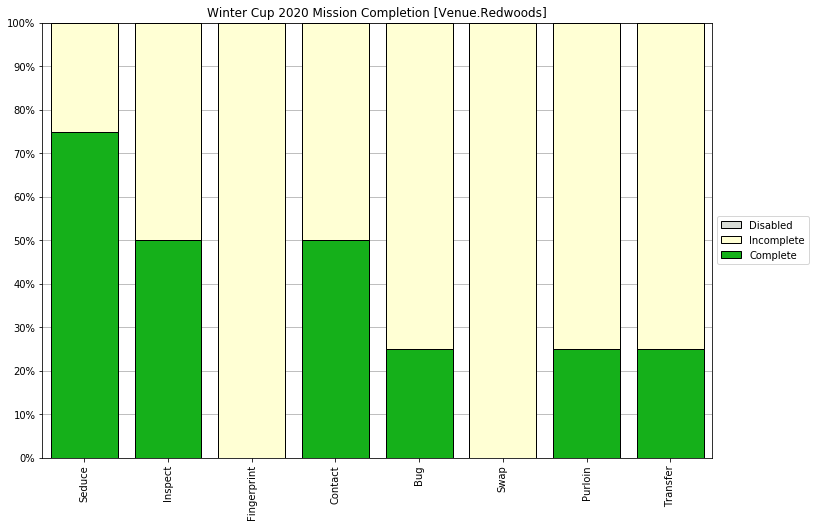

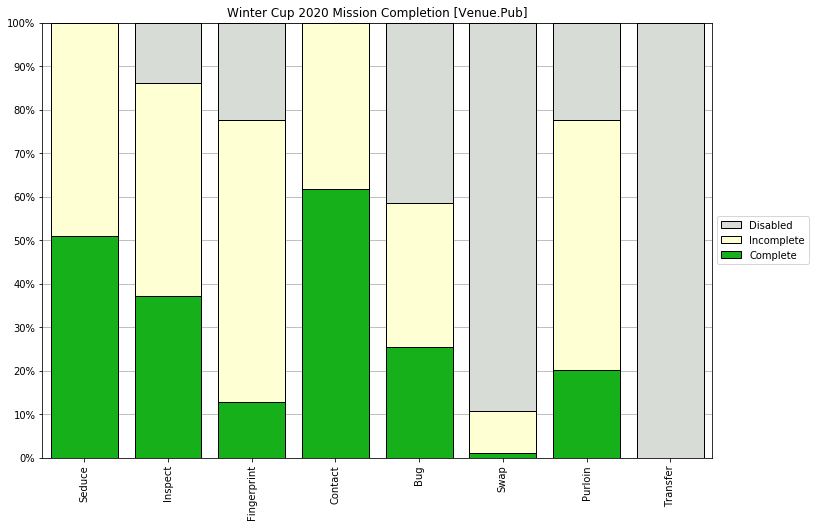

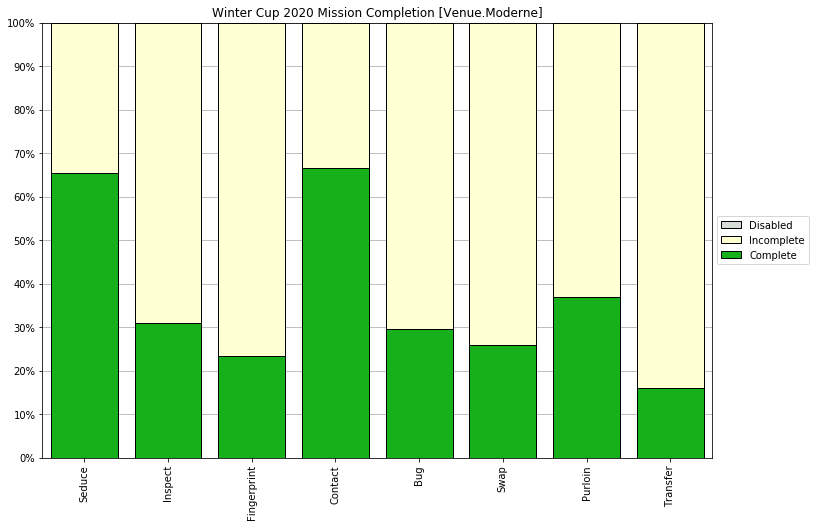

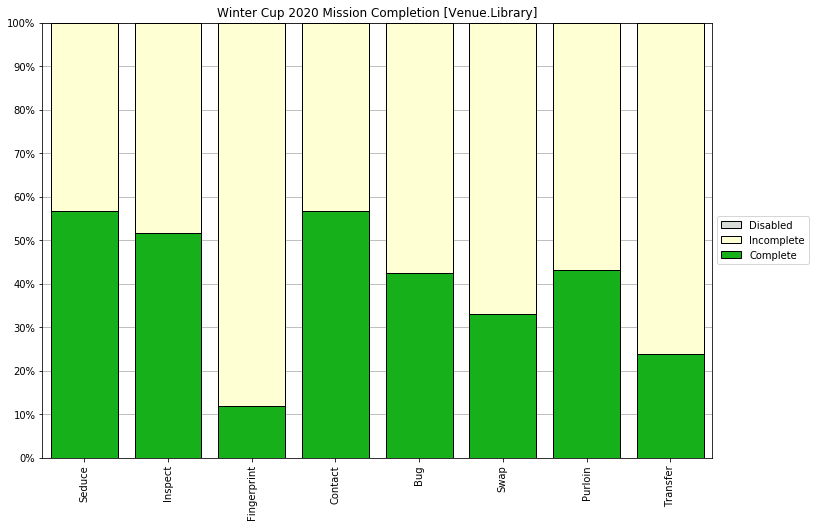

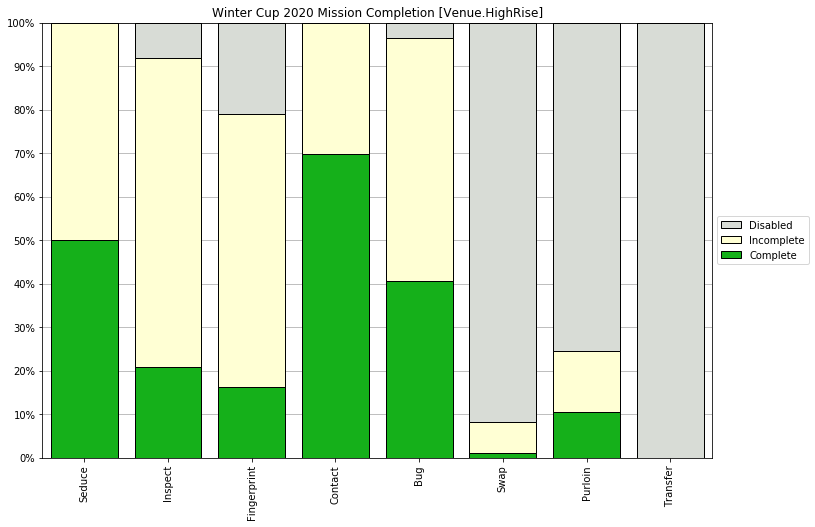

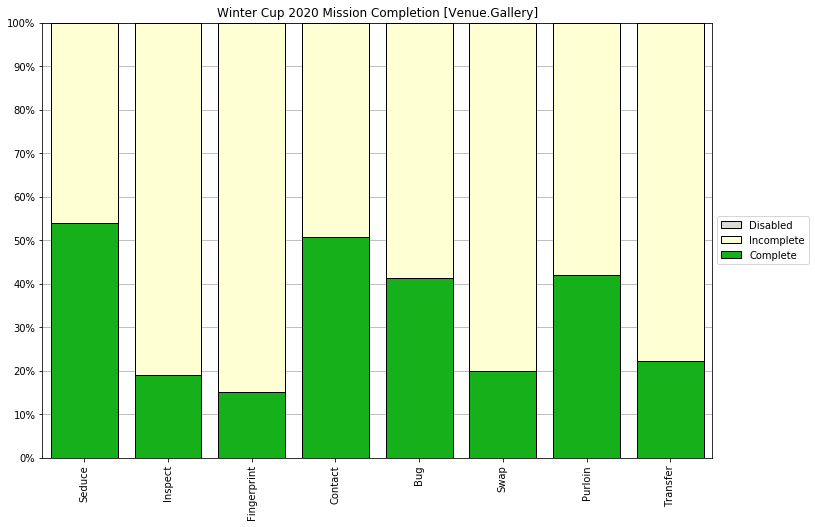

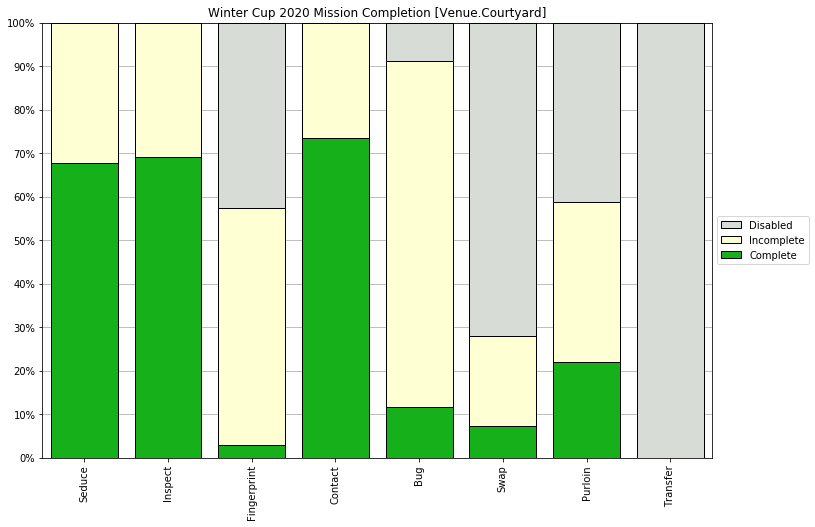

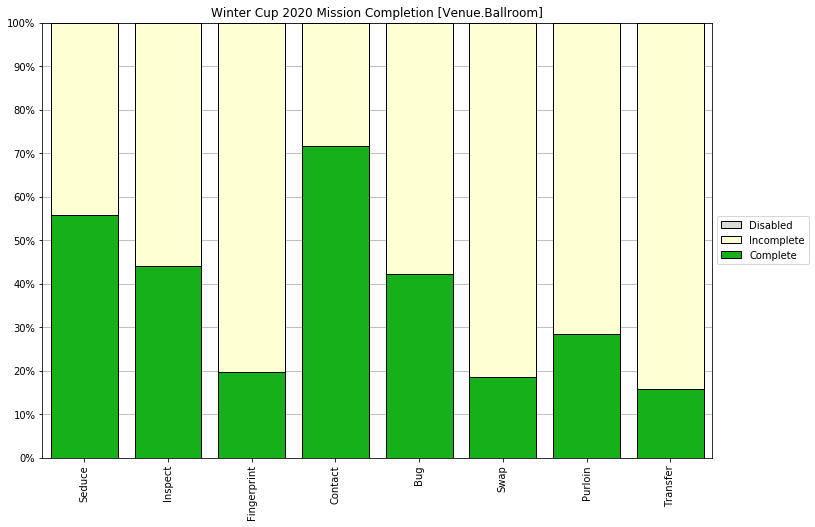

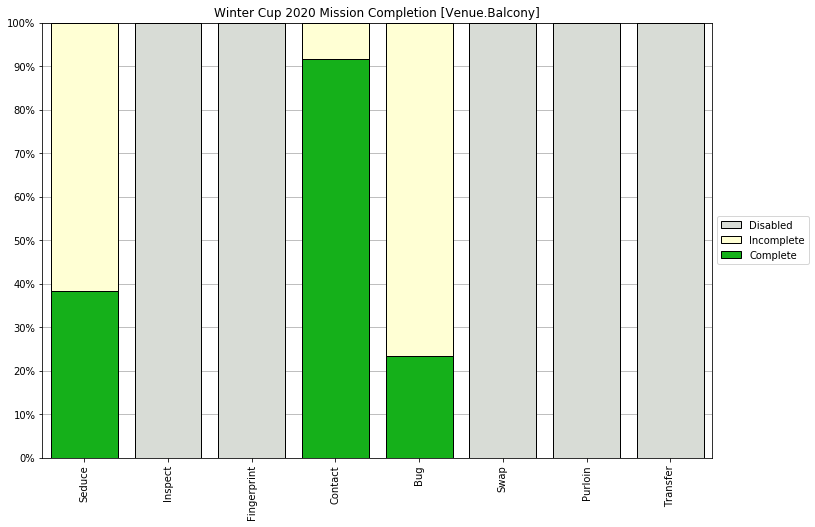

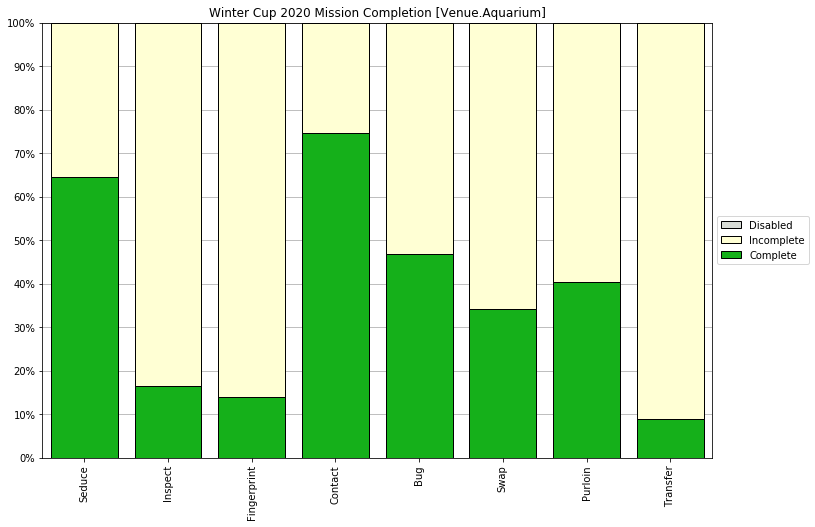

In [26]:
for venue in sorted(set([g.venue for g in replays])):
    mission_completion(list(filter(lambda g: g.venue == venue, replays)), f"Winter Cup 2020 Mission Completion [{venue}]")